# Mandatory Assignment 1

#### Part I: Multi-layer Perceptron

***

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [material/nns_pytorch.ipynb](material/nns_pytorch.ipynb)

Table of contents:
1. Activate GPU
2. Load data
3. Inspect data
4. Artificial neural network (**Where you will implement the ANN**)
5. Training hyperparameters (**Where you will add training parameters**)
6. Training
7. Plot loss and accuracy
8. Evaluate


In [64]:
# auxilary imports
import random
import matplotlib.pyplot as plt
import os
from pathlib import Path

# pytorch
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F  # noqa

First, a bit of a hack in case your IDE wants to run the notebook from /`assignment/` and not the project root folder `/ma1`. We need the working directory to be `/ma1` for local imports to work.

In [65]:
# Ensure the working directory is set to the "ma1" folder.
while Path.cwd().name != "ma1" and "ma1" in str(Path.cwd()):
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: /Users/filiprognerud/Desktop/AIML25/mas/ma1


##### Import local files

To declutter the notebooks, your are given a module (`/src`) of useful functions. Please study each one as they contain important code (particularly `src.training` and `src.evaluation`). 

In [66]:
# local files
from src.utils import get_device
from src.data import load_torch_data, to_dataloader, train_val_split
from src.training import fit
from src.evaluation import evaluate
from src.visualize import plot_training_history

### 1. Activate GPU
If available. Note that this is not necessary, but it will speed up your training.

In [67]:
# Device will determine whether to run the training on GPU or CPU.
DEVICE = get_device()

Running pytorch version (2.5.1) with backend = cpu


### 2. Load data

In [68]:
# load the training/validation data
train_val = load_torch_data(
    dataset="MNIST",
    root = 'data',                     # The root directory where the dataset will be stored
    download = True,                   # If the dataset is not found at root, it will be downloaded
    train = True,                      # The train dataset (as opposed to the test dataset)
    transform = transforms.ToTensor()  # transformations to be applied to the dataset (only cast to tensor)
)

# load the testing data
test = load_torch_data(
    dataset = "MNIST",
    root = 'data',
    download = True,
    train = False,
    transform = transforms.ToTensor()
)

f"{len(train_val)=}, {len(test)=}"

'len(train_val)=60000, len(test)=10000'

In [69]:
# split training data in training and validation (just like train_test_split in sklearn)
train, val = train_val_split(train_val, val_ratio=0.2, seed=42)

f"{len(val)=}, {len(train)=}"

'len(val)=12000, len(train)=48000'

In [70]:
# create dataloders for easy batch loading during training
train_loader = to_dataloader(train, batch_size = 64, shuffle = True)
val_loader = to_dataloader(val, batch_size = 64, shuffle = False)
test_loader = to_dataloader(test, batch_size = 64, shuffle = False)

### 3. Inspect data

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
Total pixels: 784
The label for this image: 9


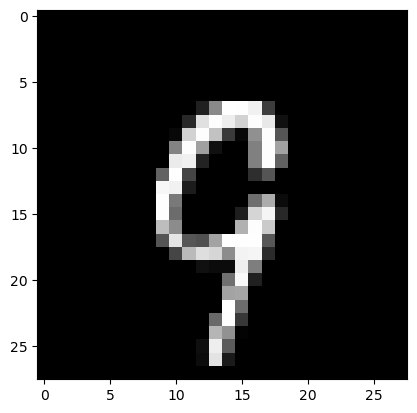

In [71]:
# Pick a random example from the training set
selection = random.randrange(len(train)-1)
image, label = train[selection]

# Plot the image
print(f"Default image shape: {image.shape}")
image = image.view([28,28])

print(f"Reshaped image shape: {image.shape}")
plt.imshow(image, cmap="gray")

print(f"Total pixels: {image.shape[0] * image.shape[1]}")

# Print the label
print(f"The label for this image: {label}")


***

### 4. Artificial neural network

In [72]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()

        # Define layers
        self.fc1 = nn.Linear(28*28, 500)  
        self.fc2 = nn.Linear(500, 10)    
        self.relu = nn.ReLU()     

    def forward(self, x: torch.Tensor):
        # Define forward pass
        x = self.relu(self.fc1(x))             
        x = self.fc2(x)      
               

        return x  

### 5. Training hyperparameters

In [73]:
LR = 0.001  # TODO: define the learning rate
NUM_EPOCHS = 15 # TODO: define the number of epochs (i.e. passes over the dataset)
criterion = nn.CrossEntropyLoss()  # The loss function

Instantiate the model and optimizer

In [74]:
model = MLP().to(DEVICE)   # Create an instance of the MLP model and move it to device (GPU or CPU)
optimizer = torch.optim.SGD(model.parameters(), lr=LR) # The optimizer (here, SGD - you can also try ADAM)

In [75]:
model

MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (relu): ReLU()
)

### 6. Training

In [76]:
model, history = fit(
    model,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    optimizer = optimizer,
    criterion = criterion,
    num_epochs = NUM_EPOCHS
)

Epoch [1/15]: Train Loss: 2.2326 | Train Accuracy: 32.45% | Val Loss: 2.1476 | Val Accuracy: 56.59%
Epoch [2/15]: Train Loss: 2.0473 | Train Accuracy: 65.54% | Val Loss: 1.9392 | Val Accuracy: 70.33%
Epoch [3/15]: Train Loss: 1.8123 | Train Accuracy: 72.04% | Val Loss: 1.6823 | Val Accuracy: 73.55%
Epoch [4/15]: Train Loss: 1.5472 | Train Accuracy: 74.64% | Val Loss: 1.4202 | Val Accuracy: 76.36%
Epoch [5/15]: Train Loss: 1.3011 | Train Accuracy: 77.58% | Val Loss: 1.1987 | Val Accuracy: 79.26%
Epoch [6/15]: Train Loss: 1.1046 | Train Accuracy: 80.16% | Val Loss: 1.0298 | Val Accuracy: 81.13%
Epoch [7/15]: Train Loss: 0.9578 | Train Accuracy: 81.78% | Val Loss: 0.9054 | Val Accuracy: 82.39%
Epoch [8/15]: Train Loss: 0.8495 | Train Accuracy: 82.97% | Val Loss: 0.8131 | Val Accuracy: 83.61%
Epoch [9/15]: Train Loss: 0.7683 | Train Accuracy: 83.90% | Val Loss: 0.7429 | Val Accuracy: 84.43%
Epoch [10/15]: Train Loss: 0.7059 | Train Accuracy: 84.62% | Val Loss: 0.6883 | Val Accuracy: 85.21%

### 7. Plot loss and accuracy

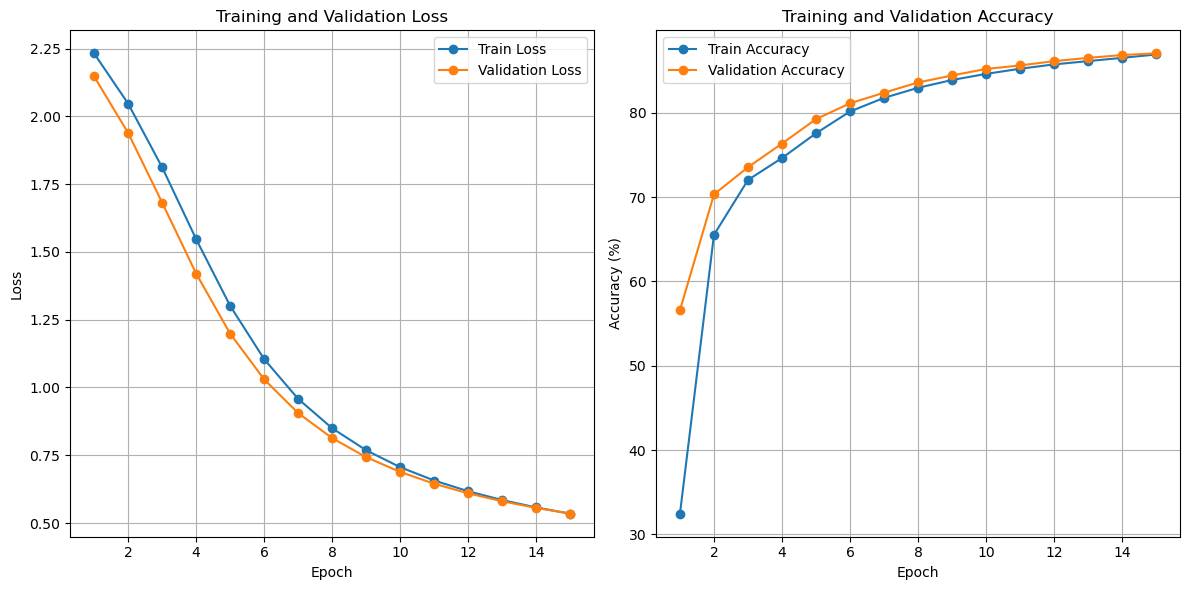

In [77]:
plot_training_history(history)

### 8. Evaluate

In [78]:
evaluate(
    model = model,
    data_loader = train_loader,  # evaluate on training data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.5237, Accuracy: 87.05%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      4735
           1       0.89      0.96      0.92      5383
           2       0.88      0.84      0.86      4762
           3       0.85      0.85      0.85      4886
           4       0.88      0.87      0.87      4681
           5       0.86      0.75      0.80      4368
           6       0.89      0.92      0.91      4752
           7       0.90      0.90      0.90      4983
           8       0.81      0.81      0.81      4674
           9       0.82      0.84      0.83      4776

    accuracy                           0.87     48000
   macro avg       0.87      0.87      0.87     48000
weighted avg       0.87      0.87      0.87     48000



In [79]:
evaluate(
    model = model,
    data_loader = val_loader,  # evaluate on validation data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.5346, Accuracy: 87.06%

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1188
           1       0.89      0.96      0.92      1359
           2       0.88      0.82      0.85      1196
           3       0.84      0.85      0.85      1245
           4       0.87      0.87      0.87      1161
           5       0.86      0.79      0.82      1053
           6       0.90      0.92      0.91      1166
           7       0.90      0.90      0.90      1282
           8       0.83      0.82      0.83      1177
           9       0.81      0.82      0.82      1173

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000



In [80]:
evaluate(
    model = model,
    data_loader = test_loader,  # evaluate on testing data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.5046, Accuracy: 87.62%

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       980
           1       0.92      0.96      0.94      1135
           2       0.89      0.84      0.86      1032
           3       0.86      0.88      0.87      1010
           4       0.87      0.88      0.87       982
           5       0.86      0.76      0.80       892
           6       0.88      0.91      0.90       958
           7       0.91      0.88      0.89      1028
           8       0.81      0.82      0.82       974
           9       0.84      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.88      0.88     10000

